In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee as mc
import corner
from astropy.io import fits
from scipy import interpolate
from scipy.optimize import newton
from SED_Funcs_custom import MagsToFluxes, InitializeExtinction
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

In [3]:
#######################################################################################
# Load in SED data

# Input observed magnitudes
magfile = 'hd219666_magnitudes'

# Convert magnitudes to fluxes
bandwavs_eff, bandwidths_eff, bandfluxes, bandfluxerrs, bandnames = MagsToFluxes(magfile, Teff=5527.)

# Create dictionary of observed info
sed_obs_dict = {
    'bands': bandnames,
    'band_wavelengths':bandwavs_eff,
    'band_widths':bandwidths_eff,
    'band_fluxes':bandfluxes,
    'band_fluxerrs':bandfluxerrs
}

# Initialize interstellar extinction model
ExtinctionBase = InitializeExtinction(sed_obs_dict)

# Input model stellar spectra
specprefix = '/home/mmmurphy/data/hd219666b/stellar_models/bt-settl-cifist/lte0'
specnames = ['50','51','52','53','54','55','56','57','58','59','60']
specsuffix = '.0-4.5-0.0a+0.0.BT-Settl.spec.7.dat.txt'
modelfiles = np.asarray([(specprefix+name+specsuffix) for name in specnames])

# Teffs in [K] for which model spectra were generated
# All generated with log g = 4.5 (cgs) and metallicity = 0
modeltemps = np.asarray([5000.,5100.,5200.,5300.,5400.,5500.,5600.,5700.,5800.,5900.,6000.])

modelwavs = []
modelfluxes = []
for file in modelfiles:
    modeldata =  np.loadtxt(file, unpack=True, skiprows=8, usecols=[0,1]) 
    wavs = modeldata[0]      # wavelength [angstrom]
    flux = modeldata[1]      # flux [erg / cm2 / s / angstrom]
            
    modelwavs.append(wavs)
    modelfluxes.append(flux)
            
modelwavs = np.asarray(modelwavs)
modelfluxes = np.asarray(modelfluxes)

# Extract model fluxes only in our bands
Nmodels = modelwavs.shape[0]
Nbands = sed_obs_dict['bands'].shape[0]
band_modelfluxes = [] # List of lists; For each band, gives the flux as function of model Teff

for band in range(Nbands):
    bandwav = sed_obs_dict['band_wavelengths'][band]  # effective band wavelength [micron]
    bandwav *= 1.e4  # convert to angstron
    bandwidth = sed_obs_dict['band_widths'][band]     # effective band width [micron]
    bandwidth *= 1.e4
    
    # boundary wavelengths [angstrom] of the band
    startwav = bandwav - 0.5*bandwidth
    endwav = bandwav + 0.5*bandwidth
    
    # For this band, contains flux as function of temperature (i.e. model)
    fluxesinband = np.asarray([])
    
    for model in range(Nmodels):
    
        # wavelengths & flux/wav at this Teff
        mwavs = modelwavs[model]
        mflux = modelfluxes[model]
    
        # indices corresponding to the band
        startwav_idx = np.searchsorted(mwavs, startwav, side='left') - 1
        endwav_idx = np.searchsorted(mwavs, endwav, side='left') - 1
        
        # Pull out flux/wave for this band
        modelbandfluxes = mflux[startwav_idx:endwav_idx]  # fluxes in [erg / cm2 / s / Angstrom]
        modelbandwaves = mwavs[startwav_idx:endwav_idx]
        
        # Integrate over the band
        meanmodelbandflux = np.mean(modelbandfluxes*modelbandwaves)      
        bandintegratedflux = meanmodelbandflux            # this is now in [erg / cm2 / s]
        
        fluxesinband = np.append(fluxesinband, bandintegratedflux)
    
    band_modelfluxes.append(fluxesinband)
    
band_modelfluxes = np.asarray(band_modelfluxes)

# Generate interpolation function for each band
InterpFuncs = {}

for band in range(Nbands):
    bandname = sed_obs_dict['bands'][band]
    
    band_interpfunc = interpolate.interp1d(modeltemps, band_modelfluxes[band], kind='linear')  
    InterpFuncs[bandname] = band_interpfunc


In [5]:
# Custom scaling errors 
#bandfluxerrs *= 2.2883350469133057

In [37]:
# # Orbital & Planetary Parameters
# lit_tc = 2458329.1996  # [day; bjd tdb]
# lit_P = 6.034460       # [day]
# lit_rprs = 0.04192       # [Rstar]
# lit_a = 13.27          # [Rstar]
# lit_i = 86.38          # [degrees]
lit_Rp = 4.71          # [Rearth]

# # RV parameters
# lit_K = 6.17           # [m/s]
# lit_e = 0.
# lit_w = 90.*(np.pi/180.)  # [radian]
# lit_par1 = np.sqrt(lit_e)*np.cos(lit_w)         
# lit_par2 = np.sqrt(lit_e)*np.sin(lit_w)
# lit_gamma = -20.0976   # [km/s]
lit_Mp = 16.6          # [Mearth]

# Stellar parameters
lit_Teff = 5527.       # [K]
lit_Rstar = 1.03       # [Rsol]
lit_Mstar = 0.92       # [Msol]
lit_plx = 10.6224      # [mas]
lit_Av = 0.1           # [mag]

# # HST systematics
# Hamp1_init = 0.0017220518249377167
# Htau1_init = 0.0038749871042222765
# Hamp2_init = 0.0014786496944103468
# Htau2_init = 0.00496319922916015

# Setting up parameter arrays
theta_init = np.asarray([
    # SED parameters
    lit_Teff,                    # 0 - Effective Stellar Temperature
    lit_Rstar,                   # 1 - Stellar radius
    lit_plx,                     # 2 - Parallax
    lit_Av,                      # 3 - V band extinction
])

param_labels = np.asarray([
    'Teff', 'Rstar', 'parallax', 'Av'
])




priors = np.asarray([
    # SED parameters
    lit_Teff,                    # 0 - Effective Stellar Temperature
    np.inf,                      # 1 - Stellar radius
    lit_plx,                     # 2 - Parallax
    np.inf                      # 3 - V band extinction
])
# set those which shouldn't have a prior to have value of infinity

c = 1. / np.log(10.)
priorserr = np.asarray([
    # SED parameters
    65.,                                              # 0 - Effective Stellar Temperature
    0.03,                                             # 1 - Stellar radius
    0.0121,                                           # 2 - Parallax
    0.01                                             #  3 - V band extinction
])

In [5]:
#################################################
# Astrophysical Models

def stellarSED(theta, bands, InterpFuncs, ExtinctionBase):
    # Unpack parameters
    Teff = theta[0]      # Effective temperature [K]
    Rstar = theta[1]     # Stellar radius [Rsol]
    plx = theta[2]       # Parallax [milli arcsec]
    Av = theta[3]        # V-band extinction [mag]
    
    # compute distance to star in [pc]
    d_pc = 1000. / plx
    #print('Distance in parsec = ', d_pc)
    
    # Convert stellar radius to [pc]
    Rstar_pc = Rstar*2.2555823856078e-8
    
    # Compute distance & radius factor
    r2d2 = (Rstar_pc / d_pc)**2
    
    # Compute extinction attenuation factor
    tau = (ExtinctionBase)*Av
    extinction = np.exp(-tau)
    
    # Compute model energies for each band
    band_modelfluxes = np.zeros(len(bands))
    for i in range(len(bands)):
        band = bands[i]
        band_modelfluxes[i] = InterpFuncs[band](Teff)
        
    # Attenuate by radius/distance
    band_modelfluxes *= r2d2
    
    # Attenuate by extinction
    band_modelfluxes *= extinction
    
    return band_modelfluxes

In [8]:
#########################################3
# Systematic error models


In [6]:
############################################
# Bayesian functions

def logLikelihood(ydata, yerr, modely):
    
    likelihoodarray = -0.5*((ydata-modely)**2/(yerr**2)) - np.log(np.sqrt(2.*np.pi*yerr*yerr))
    lnL = np.sum(likelihoodarray)
    
    return lnL

def logPriors(theta, priors, priorserr):
    
    # Limits on certain parameters
    if not (5000. <= theta[0] <= 6000.):
        # Limit Teff to interpolation range
        return -np.inf
    if not (0. < theta[3]):
        # Limit Av to be positive
        return -np.inf
    
    lnP = 0.
    for i, priorval in enumerate(priors):
        if np.isinf(priorval):
            continue
        else:
            lnP += -0.5*((priorval-theta[i])**2/(priorserr[i]**2)) - np.log(np.sqrt(2.*np.pi*priorserr[i]*priorserr[i]))
    
    return lnP

In [7]:
###############################################3
# Full model wrapper functions


def model_SED(theta, sed_dict, InterpolationFunctions, Extinction):
    # compute SED model
    model_SED = stellarSED(theta, sed_dict['bands'], InterpolationFunctions, Extinction)
    
    return model_SED

In [8]:
def lnPosterior(theta, 
               flux_SED, err_SED,
               priors, priorserr,
               sed_dict, InterpolationFuncs, ExtinctionBase,
               ):
    
    # Compute and check priors
    lnPrior_value = logPriors(theta, priors, priorserr)
    if not np.isfinite(lnPrior_value):
        return -np.inf
    
    # Compute models
    modelSED = model_SED(theta, sed_dict, InterpolationFuncs, ExtinctionBase)
    
    # Compute likelihoods
    lnLikelihood_SED = logLikelihood(flux_SED, err_SED, modelSED)
    
    lnLikelihood_value = lnLikelihood_SED

    # Compute posterior
    lnPost = lnPrior_value + lnLikelihood_value
    
    if np.isnan(lnPost):
        return -np.inf
    else:
        return lnPost

In [9]:
###############################################
# Computing test models using Literature values

# Computing models
modelSED = model_SED(theta_init, sed_obs_dict, InterpFuncs, ExtinctionBase)
    
lnPosterior_initvalue = lnPosterior(theta_init,
                                    bandfluxes, bandfluxerrs,
                                    priors, priorserr,
                                    sed_obs_dict, InterpFuncs, ExtinctionBase,
                                    )

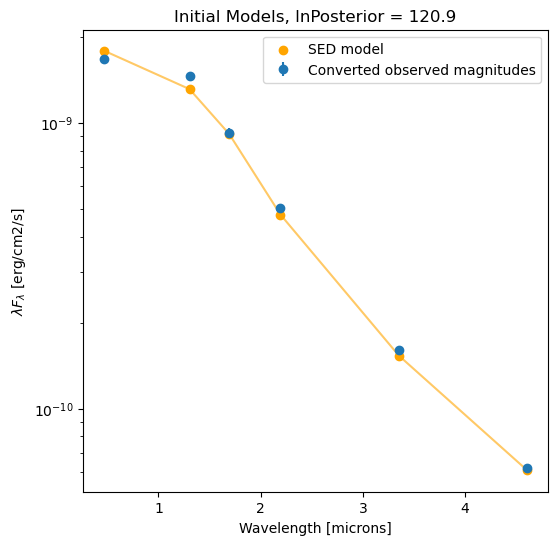

In [14]:
fig, ax = plt.subplots(nrows=1, figsize=(6,6))

ax.set_title('Initial Models, lnPosterior = %.1f'%(lnPosterior_initvalue))

ax.plot(bandwavs_eff, modelSED, c='orange', alpha=0.6)
ax.scatter(bandwavs_eff, modelSED, color='orange', label='SED model')
ax.errorbar(bandwavs_eff, bandfluxes, bandfluxerrs, ls='None', marker='o', label='Converted observed magnitudes')
ax.set_yscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'$\lambda F_\lambda$ [erg/cm2/s]')
ax.legend(loc='best');
plt.show()

In [19]:
######################################
# Setting up and initializing MCMC

Ndimensions = len(theta_init)
Nwalkers = 3*Ndimensions

# Initializing walker positions
pos = np.zeros((Nwalkers, Ndimensions))

for i in range(Ndimensions):
    pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorserr[i], Nwalkers)
    
Nsteps = 10000
logParguments = [bandfluxes, bandfluxerrs,
                priors, priorserr,
                sed_obs_dict, InterpFuncs, ExtinctionBase,
                ]



In [20]:
with Pool() as pool: 
    sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, args=logParguments, pool=pool)
    sampler.run_mcmc(pos, Nsteps, progress=True);

100%|██████████| 10000/10000 [00:28<00:00, 355.20it/s]


In [21]:
samples = sampler.get_chain()
flatsamples = sampler.get_chain(flat=True)
loglikelihoods = sampler.get_log_prob(flat=True)
#autocorrtimes = sampler.get_autocorr_time()

burn = 600
samples = samples[burn:]
flatsamples = flatsamples[burn*Nwalkers:]
loglikelihoods = loglikelihoods[burn*Nwalkers:]

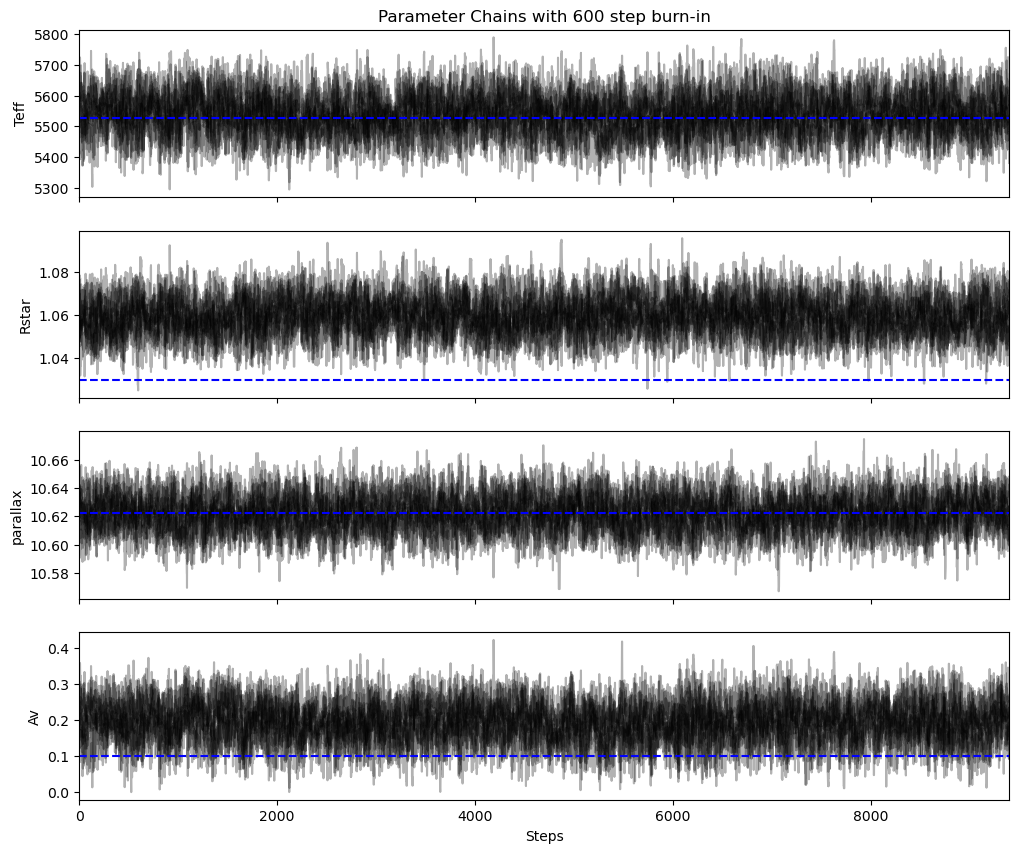

In [25]:
fig, axes = plt.subplots(samples.shape[2], figsize=(12,10), sharex=True)
for i in range(samples.shape[2]):
    ax = axes[i]
    ax.plot(samples[:,:,i], "k", alpha=0.3)
    ax.axhline(theta_init[i], c='blue', ls='--')
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(param_labels[i])
axes[0].set_title('Parameter Chains with %d step burn-in'%burn)
axes[-1].set_xlabel('Steps')
plt.show()

In [28]:
param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])

param_fiterrs = np.asarray([])
for idx, val in enumerate(param_fits):
    param_fiterrs = np.append(param_fiterrs, np.mean([param_uperrs[idx], param_loerrs[idx]]))

# Stellar SED
fitmodelSED = model_SED(param_fits, sed_obs_dict, InterpFuncs, ExtinctionBase)

residuals_sed = bandfluxes - fitmodelSED
residual_std_sed = np.std(residuals_sed)
meanerror_sed = np.mean(bandfluxerrs)
    
# Computing ln Posterior of best fit parameter array
lnPosterior_fitvalue = lnPosterior(param_fits,
                                    bandfluxes, bandfluxerrs,
                                    priors, priorserr,
                                    sed_obs_dict, InterpFuncs, ExtinctionBase,
                                    )

In [32]:
# Setting up table of parameter fit values
from tabulate import tabulate
l = []
headers = np.asarray(['Parameter', 'Median Value', 'Uncertainty', 'Initial (Literature) Value'])
for i, val in enumerate(param_labels):
    new = [param_labels[i], param_fits[i], param_fiterrs[i], theta_init[i]]
    l.append(new)
table_params = tabulate(l, headers, tablefmt='pretty')

print("Fitting Parameters")
print(table_params)

print('Residual Statistics')
resid_table_labels = np.asarray(['SED [erg/cm2/s]'])
resid_stdvals = np.asarray([residual_std_sed])
meanerrvals = np.asarray([meanerror_sed])

l = []
headers = np.asarray(['Set', 'Residual Standard Deviation', 'Mean Data Uncertainty', 'Ratio'])
for i, val in enumerate(resid_table_labels):
    l.append([resid_table_labels[i], resid_stdvals[i], meanerrvals[i], resid_stdvals[i]/meanerrvals[i]])
table_residstats = tabulate(l, headers, tablefmt='pretty')

print(table_residstats)

Fitting Parameters
+-----------+---------------------+----------------------+----------------------------+
| Parameter |    Median Value     |     Uncertainty      | Initial (Literature) Value |
+-----------+---------------------+----------------------+----------------------------+
|   Teff    | 5539.7464936094875  |  62.62979233301667   |           5527.0           |
|   Rstar   | 1.0594878731152046  | 0.00835784073558632  |            1.03            |
| parallax  | 10.622175597638847  | 0.012166451575859938 |          10.6224           |
|    Av     | 0.19369823419247167 | 0.051853352330264904 |            0.1             |
+-----------+---------------------+----------------------+----------------------------+
Residual Statistics
+-----------------+-----------------------------+-----------------------+-------------------+
|       Set       | Residual Standard Deviation | Mean Data Uncertainty |       Ratio       |
+-----------------+-----------------------------+--------------------

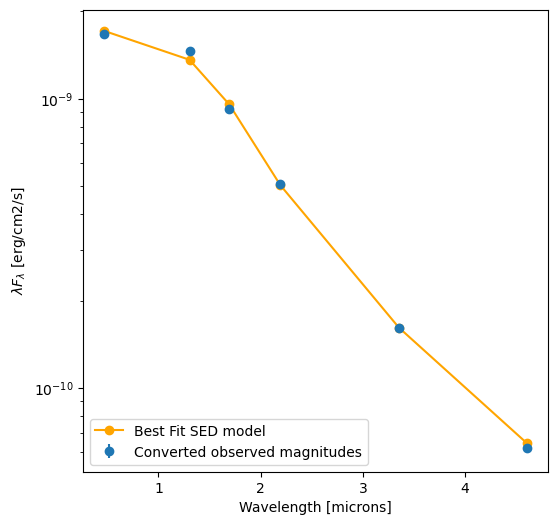

In [29]:
fig, ax = plt.subplots(figsize=(6,6), nrows=1)
ax.errorbar(bandwavs_eff, bandfluxes, bandfluxerrs, ls='None', marker='o', label='Converted observed magnitudes')
ax.plot(bandwavs_eff, fitmodelSED, color='orange', marker='o', label='Best Fit SED model')
ax.set_yscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'$\lambda F_\lambda$ [erg/cm2/s]')
ax.legend(loc='lower left');
plt.show()

## note:
to more accurately compute errors in the below, i need the full chains taken from the joint fit

In [38]:
## best fit values from joint BB + TESS + RV fit
##    to calculate derived params

# Computing derived quantities from the sample chains

def get_derived_values(valuechain):
    fitvalue = np.median(valuechain)
    fiterror = np.mean([(np.percentile(valuechain, 84) - fitvalue), (fitvalue - np.percentile(valuechain, 16))])
    return fitvalue, fiterror

# time of conjunction [day]

# orbital period [day]
fit_P = 6.034471788906
err_P = 7.87e-6

# semi-major axis [Rstar]
fit_a = 13.3555076

# inclination [degrees]
fit_inc = 86.42

# eccentricity
fit_e = 0.

# argument of periastron [deg]
fit_w = 90.

# rp/rstar in HST band 
fit_rprs_hst = 0.043749

# rp/rstar in tess band 
fit_rprs_tess = 0.042541

# RV semi-amplitude [m/s]
fit_K = 6.1467

# RV system amplitude [km/s]
fit_gamma = -20.0975

# Star effective temperature [K]
Teff_chain = flatsamples[:,0]
fit_Teff, fit_Teff_err = get_derived_values(Teff_chain)

# Star radius [Rsol]
Rstar_chain = flatsamples[:,1]
fit_Rstar, fit_Rstar_err = get_derived_values(Rstar_chain)

## to do - 
## once i get chains for a, P, etc
## change below code to use them instead of just fit values
# Star density [rho_sol]
prefactor = (365.25**2)/(215.**3)
rhostar_chain = prefactor*(fit_a**3)/(fit_P**2)
#fit_rhostar, fit_rhostar_err = get_derived_values(rhostar_chain)

# Star mass [Msol]
Mstar_chain = rhostar_chain*(Rstar_chain**3)
fit_Mstar, fit_Mstar_err = get_derived_values(Mstar_chain)

# Planet radius in HST band
rphst_chain = fit_rprs_hst * Rstar_chain  # computes Rp in units [Rstar]
rphst_chain *= 109.076                         # converts Rp to units [Rearth]; 1 Rsun = 109.076 Rearth
fit_Rphst, fit_Rphst_err = get_derived_values(rphst_chain)

# Planet radius in tess band
rptess_chain = fit_rprs_tess * Rstar_chain  # computes Rp in units [Rstar]
rptess_chain *= 109.076                         # converts Rp to units [Rearth]; 1 Rsun = 109.076 Rearth
fit_Rptess, fit_Rptess_err = get_derived_values(rptess_chain)

# Planet mass [Mearth]
G = 1.90809e5     # [Rsun * Msun^-1 * km^2/s^2]
k_kms = fit_K / 1000.         # converts to [km/s]
a_rsun = fit_a * Rstar_chain  # converts to [Rsol]
sini = np.sin(fit_a*(np.pi/180.))
Mp_chain = (k_kms / sini)*np.sqrt((a_rsun*(1. - fit_e**2))/G)*np.sqrt(Mstar_chain)  # computes Mp in units [Msun]
Mp_chain *= 332946.0487         # converts Mp to units [Mearth]
fit_Mp, fit_Mp_err = get_derived_values(Mp_chain)


# Parallax [mas]
plx_chain = flatsamples[:,2]
fit_plx, fit_plx_err = get_derived_values(plx_chain)

# V band extinction [mag]
Av_chain = flatsamples[:,3]
fit_Av, fit_Av_err = get_derived_values(Av_chain)

deriv_fits = np.asarray([fit_Rphst, fit_Rptess, fit_Mp,
                         fit_Teff, fit_Rstar, fit_Mstar, fit_plx, fit_Av])

deriv_fiterrs = np.asarray([fit_Rphst_err, fit_Rptess_err, fit_Mp_err,
                            fit_Teff_err, fit_Rstar_err, fit_Mstar_err, fit_plx_err, fit_Av_err])

deriv_labels = np.asarray(['HST Rp [Rearth]', 'TESS Rp [Rearth]', 'Mp [Mearth]',
                          'Teff [K]', 'Rstar [Rsol]', 'Mstar [Msol]', 'parallax [mas]', 'Av [mag]'])


deriv_lit = np.asarray([lit_Rp, lit_Rp, lit_Mp,
                       lit_Teff, lit_Rstar, lit_Mstar, lit_plx, lit_Av])

deriv_lit_errs = np.asarray([0.17, 0.17, 1.3,
                             65., 0.03, 0.03, 0.0121, 0.])

l = []
headers = np.asarray(['Quantity', 'Median Value', 'Mean Uncertainty', 'Literature/Initial Value', 'Literature Uncertainty'])
for i, val in enumerate(deriv_labels):
    new = [deriv_labels[i], deriv_fits[i], deriv_fiterrs[i], deriv_lit[i], deriv_lit_errs[i]]
    l.append(new)
table_derived = tabulate(l, headers, tablefmt='pretty')

print("Fitting Parameters")
print(table_params)
print(' ')
print("Derived System Quantities")
print(table_derived)

Fitting Parameters
+-----------+---------------------+----------------------+----------------------------+
| Parameter |    Median Value     |     Uncertainty      | Initial (Literature) Value |
+-----------+---------------------+----------------------+----------------------------+
|   Teff    | 5539.7464936094875  |  62.62979233301667   |           5527.0           |
|   Rstar   | 1.0594878731152046  | 0.00835784073558632  |            1.03            |
| parallax  | 10.622175597638847  | 0.012166451575859938 |          10.6224           |
|    Av     | 0.19369823419247167 | 0.051853352330264904 |            0.1             |
+-----------+---------------------+----------------------+----------------------------+
 
Derived System Quantities
+------------------+---------------------+----------------------+--------------------------+------------------------+
|     Quantity     |    Median Value     |   Mean Uncertainty   | Literature/Initial Value | Literature Uncertainty |
+------------

Old code below ...

In [24]:
# Setting up table of parameter fit values
from tabulate import tabulate
l = []
headers = np.asarray(['Parameter', 'Median Value', 'Uncertainty', 'Initial (Literature) Value'])
for i, val in enumerate(param_labels):
    new = [param_labels[i], param_fits[i], param_fiterrs[i], theta_init[i]]
    l.append(new)
table_params = tabulate(l, headers, tablefmt='pretty')

l = []
headers = np.asarray(['Quantity', 'Median Value', 'Mean Uncertainty', 'Literature/Initial Value', 'Literature Uncertainty'])
for i, val in enumerate(deriv_labels):
    new = [deriv_labels[i], deriv_fits[i], deriv_fiterrs[i], deriv_lit[i], deriv_lit_errs[i]]
    l.append(new)
table_derived = tabulate(l, headers, tablefmt='pretty')

print("Fitting Parameters")
print(table_params)
print(' ')
print("Derived System Quantities")
print(table_derived)

Fitting Parameters
+-----------+-----------------------+------------------------+----------------------------+
| Parameter |     Median Value      |      Uncertainty       | Initial (Literature) Value |
+-----------+-----------------------+------------------------+----------------------------+
|    tc     |   2458329.201866199   | 0.0005580384749919176  |        2458329.1996        |
|  log10P   |  0.7806389974506273   | 6.166822932862637e-07  |     0.7806384128736322     |
|  log10a   |  1.1237064019813392   |  0.008989258995994232  |     1.1228709228644356     |
|   cosi    |  0.06291504158429442  |  0.002059736392567575  |    0.06313889274550116     |
| sqrtecosw |  0.1468490135744936   |   0.1282185020905686   |            0.0             |
| sqrtesinw |  0.04044875250046043  |  0.14795990371859746   |            0.0             |
| rprs_hst  | 0.040587341349575576  | 0.0004407961754006144  |          0.04192           |
| rprs_tess | 0.042337979348401195  | 0.0005661807754169419  

In [323]:
#fig = corner.corner(flatsamples, labels=param_labels, show_titles=False);

In [44]:
##########################################
# Computing best fit models & de-trended data & residuals

# HST broadband
fitmodelHST = model_HSTbroadband(param_fits, t_orbit_hst, tranmodel_hst_init)
fittransitHST = transit(param_fits, tranmodel_hst_init, telescope='hst')
fithook_HST = hook(param_fits, t_orbit_hst)

dtflux_hst = flux_hst / fithook_HST
dterrs_hst = errs_hst / fithook_HST

residuals_hst = flux_hst - fitmodelHST
residual_std_hst = np.std(residuals_hst)
meanerror_hst = np.mean(errs_hst)

BFHSTtransitParams = batman.TransitParams()
BFHSTtransitParams.t0 = fit_tc        
BFHSTtransitParams.per = fit_P
BFHSTtransitParams.rp = fit_rprshst
BFHSTtransitParams.a = fit_a
BFHSTtransitParams.inc = fit_inc
BFHSTtransitParams.ecc = fit_ecc
BFHSTtransitParams.w = fit_w
BFHSTtransitParams.limb_dark = 'quadratic'
BFHSTtransitParams.u = [0.33, 0.2]

fitpresent_hst_times = np.linspace(t_bjdtdb_hst[0], t_bjdtdb_hst[-1], 100)
fittranmodel_hst_init = batman.TransitModel(BFHSTtransitParams, fitpresent_hst_times)
fitpresent_hst_model = fittranmodel_hst_init.light_curve(BFHSTtransitParams)

# TESS
fitmodelTESS = model_TESS(param_fits, tranmodel_tess_init)

residuals_tess = flux_tess - fitmodelTESS
residual_std_tess = np.std(residuals_tess)
meanerror_tess = np.mean(errs_tess)

#fitpresent_tess_times = np.linspace(fit_tc-0.75*fit_P, fit_tc+0.75*fit_P, 100)
pfphases_tess = phasefold(t_bjdtdb_tess, fit_tc, fit_P)
# it splits them weirdly, for some reason
pfphases_tess_correct = np.copy(pfphases_tess)
pfphases_tess_correct[np.where(pfphases_tess > 0.5)[0]] -= 1.

tesssort = np.argsort(pfphases_tess_correct)
fitpresent_tess_pfphases = pfphases_tess_correct[tesssort]
fitpresent_tess_pfmodel = fitmodelTESS[tesssort]


# HARPS RV
rv_phases = phasefold(t_bjdtdb_rv, fit_tc, fit_P)
fitmodelRV = model_HARPSRV(param_fits, t_bjdtdb_rv)

residuals_rv = vels_rv - fitmodelRV
residual_std_rv = np.std(residuals_rv)
meanerror_rv = np.mean(errs_rv)

fitpresent_rv_pftimes = np.linspace(fit_tc, fit_tc + fit_P - 1.e-5, 100)
fitpresent_rv_pfphases = phasefold(fitpresent_rv_pftimes, fit_tc, fit_P)
fitpresent_rv_pfmodel = radial_velocity(param_fits, fitpresent_rv_pftimes)

# Stellar SED
fitmodelSED = model_SED(param_fits, sed_obs_dict, InterpFuncs, ExtinctionBase)

residuals_sed = bandfluxes - fitmodelSED
residual_std_sed = np.std(residuals_sed)
meanerror_sed = np.mean(bandfluxerrs)
    
# Computing ln Posterior of best fit parameter array
lnPosterior_fitvalue = lnPosterior(param_fits,
                                    flux_hst, errs_hst, flux_tess, errs_tess, vels_rv, errs_rv, bandfluxes, bandfluxerrs,
                                    priors, priorserr,
                                    t_orbit_hst, t_bjdtdb_rv, sed_obs_dict, InterpFuncs, ExtinctionBase,
                                    tranmodel_hst_init, tranmodel_tess_init)

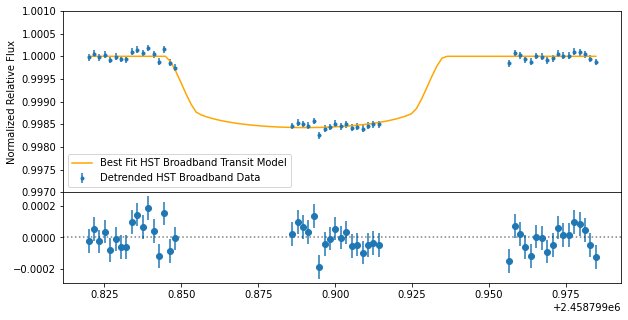

In [30]:
gridspec = dict(hspace=0., height_ratios=[1,0.5])
fig, ax = plt.subplots(nrows=2, figsize=(10,5), gridspec_kw=gridspec, sharex=True)
#fig.subplots_adjust(hspace=0)

ax[0].errorbar(t_bjdtdb_hst, dtflux_hst, dterrs_hst, ls='None', marker='o', ms=3, label='Detrended HST Broadband Data')
ax[0].plot(fitpresent_hst_times, fitpresent_hst_model, color='orange', label='Best Fit HST Broadband Transit Model')
ax[0].set_ylim(0.997, 1.001)
ax[0].set_xlabel('Time [bjd tdb]')
ax[0].set_ylabel('Normalized Relative Flux')
ax[0].legend(loc='lower left')

ax[1].errorbar(t_bjdtdb_hst, residuals_hst, dterrs_hst, ls='None', marker='o')
ax[1].axhline(0., ls='dotted', color='black', alpha=0.5)

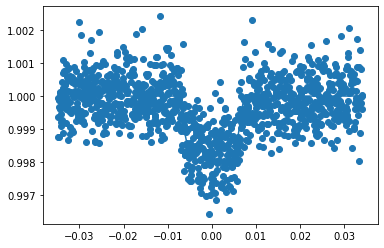

In [45]:
plt.scatter(pfphases_tess_correct, flux_tess)
plt.plot(fitpresent_tess_pfphases, fitpresent_tess_pfmodel)
#plt.xlim((0.9, 1.1))

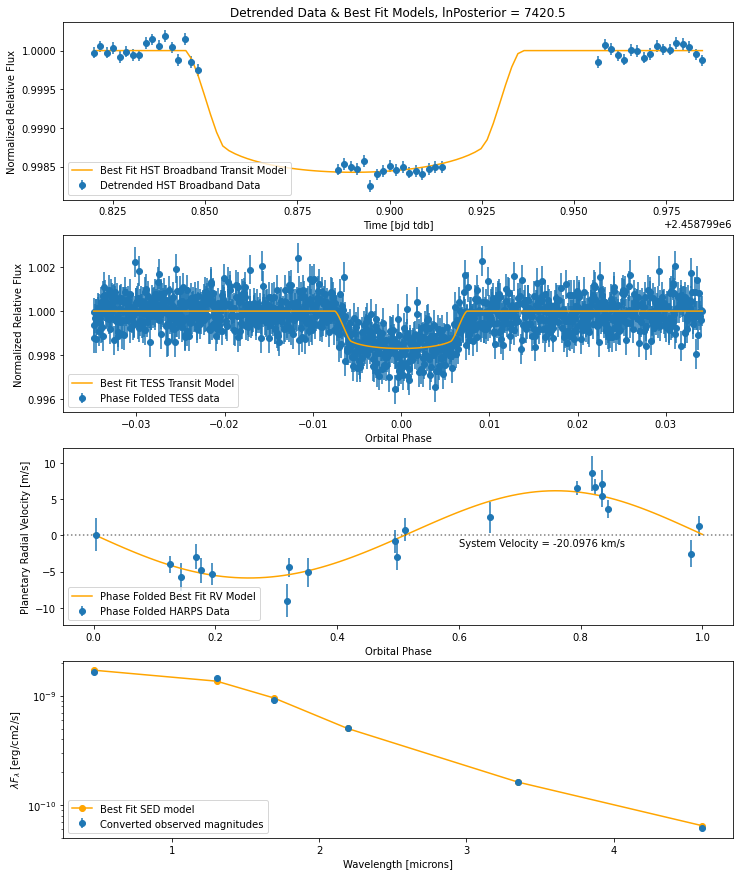

In [49]:
fig, ax = plt.subplots(nrows=4, figsize=(12,15))

ax[0].set_title('Detrended Data & Best Fit Models, lnPosterior = %.1f'%(lnPosterior_fitvalue))

ax[0].errorbar(t_bjdtdb_hst, dtflux_hst, dterrs_hst, ls='None', marker='o', label='Detrended HST Broadband Data')
ax[0].plot(fitpresent_hst_times, fitpresent_hst_model, color='orange', label='Best Fit HST Broadband Transit Model')
ax[0].set_xlabel('Time [bjd tdb]')
ax[0].set_ylabel('Normalized Relative Flux')
ax[0].legend(loc='lower left')

ax[1].errorbar(pfphases_tess_correct, flux_tess, errs_tess, ls='None', marker='o', label='Phase Folded TESS data')
ax[1].plot(fitpresent_tess_pfphases, fitpresent_tess_pfmodel, color='orange', zorder=5, label='Best Fit TESS Transit Model')
#ax[1].errorbar(t_bjdtdb_tess, flux_tess, errs_tess, ls='None', marker='o', label='TESS data')
#ax[1].plot(t_bjdtdb_tess, fitmodelTESS, color='orange', label='Best Fit TESS Transit Model')
#ax[1].text(t_bjdtdb_tess[200], 0.996, 'Inset on 1 of 4 transits')
#ax[1].set_xlim(t_bjdtdb_tess[0], t_bjdtdb_tess[280])
ax[1].set_xlabel('Orbital Phase')
ax[1].set_ylabel('Normalized Relative Flux')
ax[1].legend(loc='lower left')

ax[2].errorbar(rv_phases, (vels_rv - fit_gamma)*1000., errs_rv*1000, ls='None', marker='o', label='Phase Folded HARPS Data')
ax[2].plot(fitpresent_rv_pfphases, (fitpresent_rv_pfmodel - fit_gamma)*1000., color='orange', label='Phase Folded Best Fit RV Model')
ax[2].axhline(0., ls='dotted', color='black', alpha=0.5)
ax[2].text(0.6, -1.5, 'System Velocity = %.4f km/s'%(fit_gamma))
ax[2].set_xlabel('Orbital Phase')
ax[2].set_ylabel('Planetary Radial Velocity [m/s]')
ax[2].legend(loc='lower left')

ax[3].errorbar(bandwavs_eff, bandfluxes, bandfluxerrs, ls='None', marker='o', label='Converted observed magnitudes')
ax[3].plot(bandwavs_eff, fitmodelSED, color='orange', marker='o', label='Best Fit SED model')
ax[3].set_yscale('log')
ax[3].set_xlabel('Wavelength [microns]')
ax[3].set_ylabel(r'$\lambda F_\lambda$ [erg/cm2/s]')
ax[3].legend(loc='lower left');

Residual Statistics
+---------------------+-----------------------------+-----------------------+--------------------+
|         Set         | Residual Standard Deviation | Mean Data Uncertainty |       Ratio        |
+---------------------+-----------------------------+-----------------------+--------------------+
| HST Broadband [ppm] |      80.29694778260092      |   75.35142859251296   | 1.0656327196771869 |
|     TESS [ppm]      |      675.8331828903036      |   675.8883246220648   | 0.9999184159131732 |
|   HARPS RV [m/s]    |     1.6667024896969806      |  1.6784237524090504   | 0.9930165056975354 |
|   SED [erg/cm2/s]   |   4.7592535690596146e-11    | 4.907133262757509e-11 | 0.9698643411989192 |
+---------------------+-----------------------------+-----------------------+--------------------+
